In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing

sys.path.append("..")
from helpers import filename_for

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
class DataGeneratorBars(keras.utils.Sequence):
    def __init__(self, config):
        self.c = config

        self.labels = []
        self.features = []

        self.scaler_tri = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_e = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_t = sklearn.preprocessing.MaxAbsScaler()

        file = filename_for(
            self.c["distance"],
            self.c["doubleplane"],
            self.c["energy"],
            self.c["erel"],
            self.c["neutrons"][0],
            "inclxx",
            self.c["subruns"][0],
            "bars.parquet",
        )
        data = pd.read_parquet(file)
        rows = len(data.index)
        del data

        self.batches_per_subrun = (rows * len(self.c["neutrons"])) // self.c["batch_size"]
        self.batches_per_cache = self.batches_per_subrun * self.c["subrun_cache_size"]
        self.len = self.batches_per_subrun * len(self.c["subruns"])

        self.cache_subruns = [
            self.c["subruns"][i : i + self.c["subrun_cache_size"]]
            for i in range(0, len(self.c["subruns"]), self.c["subrun_cache_size"])
        ]
        self.current_cache = -1

        print(f"Rows in one file: {rows}")
        print(f"{self.batches_per_subrun} batches per subrun")
        print(f"{self.len} total batches in {self.cache_subruns} caches")

        self.fitscalers()
        self.load(0)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        cacheid = index // self.batches_per_cache
        i = index % (self.batches_per_cache)
        # print(f"{index} -> c{cacheid}-i{i}")

        if cacheid != self.current_cache:
            self.load(cacheid)

        a = i * self.c["batch_size"]
        b = (i + 1) * self.c["batch_size"]

        x = self.features[a:b]
        y = self.labels[a:b]
        return x, y

    def load(self, cacheid):
        subruns = self.cache_subruns[cacheid]
        print(f"Loading subruns {subruns} for cache {cacheid}")

        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True).sample(frac=1)
        data.loc[data["nHits"] == 0, self.c["label"]] = 0

        self.current_cache = cacheid
        self.features = np.concatenate(
            (
                # self.scaler_tri.transform(data[self.c["cols_tri"]]),
                self.scaler_e.transform(data[self.c["cols_e"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_e"])
                ),
                self.scaler_t.transform(data[self.c["cols_t"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_t"])
                ),
            ),
            axis=1,
        )
        self.labels = keras.utils.to_categorical(
            data[[self.c["label"]]].values.ravel(), num_classes=len(self.c["neutrons"]) + 1
        )
        del data

    def fitscalers(self):
        subruns = range(5)  # self.cache_subruns[0]
        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)
        # self.scaler_tri.fit(data[self.c["cols_tri"]])
        self.scaler_e.fit(data[self.c["cols_e"]].values.reshape(-1, 1))
        self.scaler_t.fit(data[self.c["cols_t"]].values.reshape(-1, 1))
        del data

In [4]:
config = {
    "distance": 15,
    "doubleplane": 30,
    "energy": 600,
    "erel": 500,
    "neutrons": [1, 2, 3, 4],
    "subruns": range(6),  # range(19),
    "subrun_cache_size": 6,
    "batch_size": 100,
    "label": "nPN",
}

validation_config = config.copy()
validation_config["subruns"] = [19]

In [5]:
generator = DataGeneratorBars(config)
validation_generator = DataGeneratorBars(validation_config)

Rows in one file: 10000
400 batches per subrun
2400 total batches in [range(0, 6)] caches
Loading subruns range(0, 6) for cache 0
Rows in one file: 10000
400 batches per subrun
400 total batches in [[19]] caches
Loading subruns [19] for cache 0


In [6]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model1.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history1 = model1.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 7s - loss: 1.2913 - accuracy: 0.4893 - val_loss: 1.1485 - val_accuracy: 0.5704
Epoch 2/10
2400/2400 - 6s - loss: 1.0863 - accuracy: 0.5803 - val_loss: 1.0416 - val_accuracy: 0.5889
Epoch 3/10
2400/2400 - 6s - loss: 1.0074 - accuracy: 0.5982 - val_loss: 0.9840 - val_accuracy: 0.5997
Epoch 4/10
2400/2400 - 6s - loss: 0.9594 - accuracy: 0.6074 - val_loss: 0.9461 - val_accuracy: 0.6046
Epoch 5/10
2400/2400 - 6s - loss: 0.9268 - accuracy: 0.6138 - val_loss: 0.9200 - val_accuracy: 0.6080
Epoch 6/10
2400/2400 - 6s - loss: 0.9035 - accuracy: 0.6175 - val_loss: 0.9010 - val_accuracy: 0.6108
Epoch 7/10
2400/2400 - 6s - loss: 0.8861 - accuracy: 0.6209 - val_loss: 0.8865 - val_accuracy: 0.6137
Epoch 8/10
2400/2400 - 6s - loss: 0.8725 - accuracy: 0.6237 - val_loss: 0.8752 - val_accuracy: 0.6154
Epoch 9/10
2400/2400 - 6s - loss: 0.8615 - accuracy: 0.6256 - val_loss: 0.8660 - val_accuracy: 0.6176
Epoch 10/10
2400/2400 - 6s - loss: 0.8525 - accuracy: 0.6274 - val_loss: 0.8584 - 

In [7]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(units=10, activation="relu"))
model2.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model2.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history2 = model2.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 6s - loss: 1.0344 - accuracy: 0.5661 - val_loss: 0.8644 - val_accuracy: 0.6281
Epoch 2/10
2400/2400 - 6s - loss: 0.8349 - accuracy: 0.6314 - val_loss: 0.8182 - val_accuracy: 0.6354
Epoch 3/10
2400/2400 - 6s - loss: 0.8007 - accuracy: 0.6378 - val_loss: 0.7975 - val_accuracy: 0.6377
Epoch 4/10
2400/2400 - 6s - loss: 0.7839 - accuracy: 0.6416 - val_loss: 0.7883 - val_accuracy: 0.6380
Epoch 5/10
2400/2400 - 6s - loss: 0.7743 - accuracy: 0.6468 - val_loss: 0.7832 - val_accuracy: 0.6496
Epoch 6/10
2400/2400 - 6s - loss: 0.7674 - accuracy: 0.6566 - val_loss: 0.7804 - val_accuracy: 0.6478
Epoch 7/10
2400/2400 - 6s - loss: 0.7617 - accuracy: 0.6577 - val_loss: 0.7776 - val_accuracy: 0.6476
Epoch 8/10
2400/2400 - 6s - loss: 0.7567 - accuracy: 0.6597 - val_loss: 0.7756 - val_accuracy: 0.6480
Epoch 9/10
2400/2400 - 6s - loss: 0.7520 - accuracy: 0.6617 - val_loss: 0.7740 - val_accuracy: 0.6474
Epoch 10/10
2400/2400 - 6s - loss: 0.7478 - accuracy: 0.6634 - val_loss: 0.7736 - 

In [8]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Dense(units=100, activation="relu"))
model3.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model3.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history3 = model3.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 7s - loss: 0.8858 - accuracy: 0.6088 - val_loss: 0.7953 - val_accuracy: 0.6389
Epoch 2/10
2400/2400 - 6s - loss: 0.7784 - accuracy: 0.6449 - val_loss: 0.7735 - val_accuracy: 0.6515
Epoch 3/10
2400/2400 - 6s - loss: 0.7564 - accuracy: 0.6580 - val_loss: 0.7632 - val_accuracy: 0.6514
Epoch 4/10
2400/2400 - 6s - loss: 0.7382 - accuracy: 0.6662 - val_loss: 0.7570 - val_accuracy: 0.6567
Epoch 5/10
2400/2400 - 6s - loss: 0.7210 - accuracy: 0.6751 - val_loss: 0.7525 - val_accuracy: 0.6561
Epoch 6/10
2400/2400 - 6s - loss: 0.7049 - accuracy: 0.6842 - val_loss: 0.7517 - val_accuracy: 0.6553
Epoch 7/10
2400/2400 - 6s - loss: 0.6888 - accuracy: 0.6937 - val_loss: 0.7530 - val_accuracy: 0.6554
Epoch 8/10
2400/2400 - 6s - loss: 0.6732 - accuracy: 0.7028 - val_loss: 0.7554 - val_accuracy: 0.6566
Epoch 9/10
2400/2400 - 6s - loss: 0.6580 - accuracy: 0.7118 - val_loss: 0.7583 - val_accuracy: 0.6551
Epoch 10/10
2400/2400 - 6s - loss: 0.6434 - accuracy: 0.7202 - val_loss: 0.7642 - 

In [9]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Dense(units=1000, activation="relu"))
model4.add(keras.layers.Dense(units=100, activation="relu"))
model4.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model4.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history4 = model4.fit(generator, verbose=2, epochs=10, shuffle=True, validation_data=validation_generator)

Epoch 1/10
2400/2400 - 11s - loss: 0.8134 - accuracy: 0.6275 - val_loss: 0.7643 - val_accuracy: 0.6529
Epoch 2/10
2400/2400 - 11s - loss: 0.7355 - accuracy: 0.6648 - val_loss: 0.7397 - val_accuracy: 0.6635
Epoch 3/10
2400/2400 - 11s - loss: 0.6608 - accuracy: 0.7057 - val_loss: 0.7428 - val_accuracy: 0.6650
Epoch 4/10
2400/2400 - 11s - loss: 0.5475 - accuracy: 0.7691 - val_loss: 0.8146 - val_accuracy: 0.6515
Epoch 5/10
2400/2400 - 11s - loss: 0.3974 - accuracy: 0.8434 - val_loss: 0.9706 - val_accuracy: 0.6415
Epoch 6/10
2400/2400 - 11s - loss: 0.2561 - accuracy: 0.9070 - val_loss: 1.2719 - val_accuracy: 0.6360
Epoch 7/10
2400/2400 - 11s - loss: 0.1635 - accuracy: 0.9434 - val_loss: 1.6342 - val_accuracy: 0.6265
Epoch 8/10
2400/2400 - 11s - loss: 0.1144 - accuracy: 0.9614 - val_loss: 1.9192 - val_accuracy: 0.6246
Epoch 9/10
2400/2400 - 11s - loss: 0.0864 - accuracy: 0.9714 - val_loss: 2.2228 - val_accuracy: 0.6208
Epoch 10/10
2400/2400 - 11s - loss: 0.0704 - accuracy: 0.9765 - val_loss:

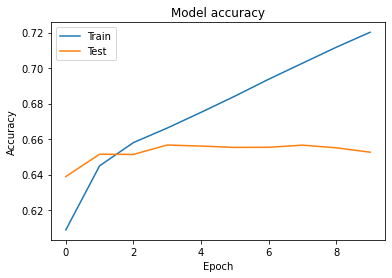

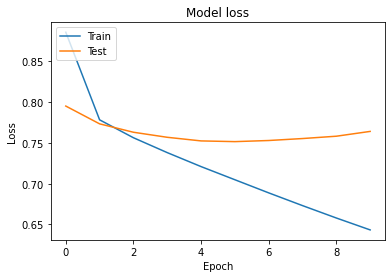

In [16]:
# Plot training & validation accuracy values
plt.plot(history3.history["accuracy"])
plt.plot(history3.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [12]:
del generator
del validation_generator

In [13]:
test_config = config.copy()
test_config["subruns"] = range(14, 19)
test_generator = DataGeneratorBars(test_config)

Rows in one file: 10000
400 batches per subrun
2000 total batches in [range(14, 19)] caches
Loading subruns range(14, 19) for cache 0


In [14]:
X = test_generator.features
y_true = np.argmax(test_generator.labels, axis=1)

In [15]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for model in [model1, model2, model3, model4]:
    y_pred = np.argmax(model.predict(X), axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(bac)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1))
    print(cm)
    cmrel = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1), normalize="true")
    print((cmrel * 100).round())

0.5005759965492517
[[    0  2553     0     0     0]
 [    0 40884  6609    58    11]
 [    0 12151 24958 11951   831]
 [    0  2149 10945 20487 16414]
 [    0   302  2870 10165 36662]]
[[  0. 100.   0.   0.   0.]
 [  0.  86.  14.   0.   0.]
 [  0.  24.  50.  24.   2.]
 [  0.   4.  22.  41.  33.]
 [  0.   1.   6.  20.  73.]]
0.7161250452488167
[[ 2553     0     0     0     0]
 [  347 42148  5020    25    22]
 [   43 11814 26444 11112   478]
 [    2  1977 11033 23016 13967]
 [    1   302  2746 11748 35202]]
[[100.   0.   0.   0.   0.]
 [  1.  89.  11.   0.   0.]
 [  0.  24.  53.  22.   1.]
 [  0.   4.  22.  46.  28.]
 [  0.   1.   5.  23.  70.]]
0.7207049212714788
[[ 2553     0     0     0     0]
 [  373 42788  4335    47    19]
 [   44 10665 29861  8463   858]
 [    3  1680 13324 19975 15013]
 [    1   217  3453 11037 35291]]
[[100.   0.   0.   0.   0.]
 [  1.  90.   9.   0.   0.]
 [  0.  21.  60.  17.   2.]
 [  0.   3.  27.  40.  30.]
 [  0.   0.   7.  22.  71.]]
0.6938053236644823
[[ 

In [ ]:
import numpy as np
import pandas as pd
import sklearn.preprocessing


class DataGeneratorBars(keras.utils.Sequence):
    def __init__(self, config):
        self.c = config

        self.cols_tri = ["nHits", "nClus", "Edep"]
        self.cols_e = [str(i) for i in range(0, self.c["doubleplane"] * 100 * 2, 2)]
        self.cols_t = [str(i + 1) for i in range(0, self.c["doubleplane"] * 100 * 2, 2)]

        self.labels = []
        self.features = []

        self.scaler_tri = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_e = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_t = sklearn.preprocessing.MaxAbsScaler()

        file = filename_for(
            self.c["distance"],
            self.c["doubleplane"],
            self.c["energy"],
            self.c["erel"],
            self.c["neutrons"][0],
            "inclxx",
            self.c["subruns"][0],
            "bars.parquet",
        )
        data = pd.read_parquet(file)
        rows = len(data.index)
        del data

        self.batches_per_subrun = (rows * len(self.c["neutrons"])) // self.c["batch_size"]
        self.batches_per_cache = self.batches_per_subrun * self.c["subrun_cache_size"]
        self.len = self.batches_per_subrun * len(self.c["subruns"])

        self.cache_subruns = [
            self.c["subruns"][i : i + self.c["subrun_cache_size"]]
            for i in range(0, len(self.c["subruns"]), self.c["subrun_cache_size"])
        ]
        self.current_cache = -1

        print(f"Rows in one file: {rows}")
        print(f"{self.batches_per_subrun} batches per subrun")
        print(f"{self.len} total batches in {self.cache_subruns} caches")

        self.fitscalers()
        self.load(0)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        cacheid = index // self.batches_per_cache
        i = index % (self.batches_per_cache)
        # print(f"{index} -> c{cacheid}-i{i}")

        if cacheid != self.current_cache:
            self.load(cacheid)

        a = i * self.c["batch_size"]
        b = (i + 1) * self.c["batch_size"]

        x = self.features[a:b]
        y = self.labels[a:b]
        return x, y

    def load(self, cacheid):
        subruns = self.cache_subruns[cacheid]
        print(f"Loading subruns {subruns} for cache {cacheid}")

        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True).sample(frac=1)
        data.loc[data["nHits"] == 0, self.c["label"]] = 0

        self.current_cache = cacheid

        if self.c["mode"] == "bars":
            self.features = np.concatenate(
                (
                    self.scaler_e.transform(data[self.c["cols_e"]].values.reshape(-1, 1)).reshape(
                        -1, len(self.c["cols_e"])
                    ),
                    self.scaler_t.transform(data[self.c["cols_t"]].values.reshape(-1, 1)).reshape(
                        -1, len(self.c["cols_t"])
                    ),
                ),
                axis=1,
            )
        elif self.c["mode"] == "barstri":
            self.features = np.concatenate(
                (
                    self.scaler_tri.transform(data[self.c["cols_tri"]]),
                    self.scaler_e.transform(data[self.c["cols_e"]].values.reshape(-1, 1)).reshape(
                        -1, len(self.c["cols_e"])
                    ),
                    self.scaler_t.transform(data[self.c["cols_t"]].values.reshape(-1, 1)).reshape(
                        -1, len(self.c["cols_t"])
                    ),
                ),
                axis=1,
            )

        self.labels = keras.utils.to_categorical(
            data[[self.c["label"]]].values.ravel(), num_classes=len(self.c["neutrons"]) + 1
        )
        del data

    def fitscalers(self):
        subruns = range(5)  # self.cache_subruns[0]
        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)
        self.scaler_tri.fit(data[self.c["cols_tri"]])
        self.scaler_e.fit(data[self.c["cols_e"]].values.reshape(-1, 1))
        self.scaler_t.fit(data[self.c["cols_t"]].values.reshape(-1, 1))
        del data